In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold

from sklearn.metrics import log_loss

import xgboost as xgb

/home/ivan/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_columns = 999
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [3]:
from time import time

In [4]:
X_train = pd.read_csv('train.csv')

In [15]:
def Score(cell):
    
    words1 = [w.lower() for w in str(cell['question1']).split()]
    words2 = [w.lower() for w in str(cell['question2']).split()]
    
#    return 2 * len([w for w in words1 if w in words2]) / (len(words1) + len(words2))

# Все же правильно так в числителе:

    return (len([w for w in words1 if w in words2]) + len([w for w in words2 if w in words1])) \
            / (len(words1) + len(words2))

# Расхождение может быть из-за длины слов и повторений !


In [6]:
start = time()

X_train['score'] = X_train.apply(Score, axis=1)

print ('final time', time() - start)

final time 33.38507437705994


In [16]:
# Посчитаем по-новому

start = time()

X_train['score2'] = X_train.apply(Score, axis=1)

print ('final time', time() - start)

final time 35.43504023551941


In [10]:
X_train['score'].value_counts().iloc[:10]

0.000    22369
0.667    16291
0.500    14773
0.400    11352
0.333     8696
0.571     8477
0.286     6986
0.800     6643
0.444     6633
0.250     6015
Name: score, dtype: int64

In [17]:
X_train['score2'].value_counts().iloc[:10]

0.000    22369
0.500    14803
0.667    14375
0.400     9674
0.333     8752
0.571     7305
0.250     5995
0.800     5963
0.286     5924
0.750     5851
Name: score2, dtype: int64

In [18]:
# Groups out of scores

X_train['score_group'] = ((X_train['score'] * 100).round()).astype(int)

In [19]:
len(X_train['score_group'].value_counts())

121

In [20]:
X_train['score_group'].value_counts().iloc[:10]

0     22369
67    16291
50    14774
40    11355
62     9488
33     9103
38     8871
53     8631
57     8510
71     8226
Name: score_group, dtype: int64

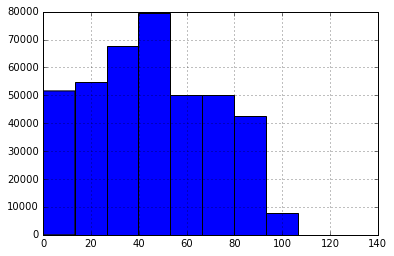

In [58]:
X_train['score_group'].hist()

In [ ]:
# Let's do XGBoost just with just score and score_group...

In [26]:
# Base results

params = {'objective':'binary:logistic',
         'n_estimators':100,
         'learning_rate':0.02,
         'max_depth':3,
         'nthread':-1,
         'base_score':0.5}

clf = xgb.XGBClassifier(**params)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

result = []

for train, test in kf.split(X_train):
    
    data_train = X_train.iloc[train][['id','score','score_group','is_duplicate']]
    data_test = X_train.iloc[test][['id','score','score_group','is_duplicate']]
    
    clf.fit(data_train[['id','score','score_group']], data_train['is_duplicate'])

    pred = clf.predict_proba(data_test[['id','score','score_group']])
    true = data_test['is_duplicate'].values
    
#    xgb.plot_importance(clf)
    
    result += [log_loss(true, pred)]
       
    
print ('Results:', [result[i] for i in range(len(result))])
print ('Mean:', pd.DataFrame(result).mean()[0])

Results: [0.54940352297556172, 0.54789963135665087, 0.54591774101478707]
Mean: 0.547740298449


In [23]:
# Check this out:
# I am checking two ideas which both give me more boost than Semenych or spell check!!!
# First. Why don't we set a base_score of 0.17 as it is the 'base' prediction (globalmean)

params = {'objective':'binary:logistic',
         'n_estimators':100,
         'learning_rate':0.02,
         'max_depth':3,
         'nthread':-1,
         'base_score':0.17}

clf = xgb.XGBClassifier(**params)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

result = []

for train, test in kf.split(X_train):
    
    data_train = X_train.iloc[train][['id','score','score_group','is_duplicate']]
    data_test = X_train.iloc[test][['id','score','score_group','is_duplicate']]
    
    clf.fit(data_train[['id','score','score_group']], data_train['is_duplicate'])

    pred = clf.predict_proba(data_test[['id','score','score_group']])
    true = data_test['is_duplicate'].values
    
#    xgb.plot_importance(clf)
    
    result += [log_loss(true, pred)]
       
    
print ('Results:', [result[i] for i in range(len(result))])
print ('Mean:', pd.DataFrame(result).mean()[0])

Results: [0.54461859704000626, 0.54277195660910127, 0.54036990542553265]
Mean: 0.542586819692


In [24]:
# Second. Why don't we use the correct score2 instead of score.

params = {'objective':'binary:logistic',
         'n_estimators':100,
         'learning_rate':0.02,
         'max_depth':3,
         'nthread':-1,
         'base_score':0.17}

clf = xgb.XGBClassifier(**params)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

result = []

for train, test in kf.split(X_train):
    
    data_train = X_train.iloc[train][['id','score2','score_group','is_duplicate']]
    data_test = X_train.iloc[test][['id','score2','score_group','is_duplicate']]
    
    clf.fit(data_train[['id','score2','score_group']], data_train['is_duplicate'])

    pred = clf.predict_proba(data_test[['id','score2','score_group']])
    true = data_test['is_duplicate'].values
    
#    xgb.plot_importance(clf)
    
    result += [log_loss(true, pred)]
       
    
print ('Results:', [result[i] for i in range(len(result))])
print ('Mean:', pd.DataFrame(result).mean()[0])

# Both base_score=0.17 and score 2 instead of score 

Results: [0.54063935064497581, 0.53916813187443746, 0.53663928723845045]
Mean: 0.538815589919


# Time for Semenych

In [13]:
def Semenych(data_train, data_test, N_SPLITS=3, alpha=10):

    # At first we need to split the train and use these splits to calculate
    # semen (I understand English, it's just to make it more memorable) 
    # for each split using other splits to avoid over-fitting.

    # Instead of using another k-fold, I construct my own splitting. 

    # Reset index. Will reset it back at the end.
    data_train = data_train.reset_index()
    
    # What if columns have different names? We need the order, but the names are unimportant.
    # The order: ['cat_group_var','semen_var','Y']
    
    columns_old_train = data_train.columns
    columns_old_test = data_test.columns
        
    data_train.columns = ['index','price_group_2','semen_price','Y']
    data_test.columns = ['price_group_2','semen_price','Y']
    
    data_train['semen_price'] = 0.0 # Initialize, nothing more
    data_test['semen_price'] = 0.0
    data_test['Y'] = 0 # Usually there is none
    
    # Let's prepare unique categories (I sort them for beauty). Need those combined with test's. 
    unique_cats = sorted(np.unique(np.hstack((data_train['price_group_2'].unique(),data_test['price_group_2'].unique()))))
        
    ## Prepare splits for train

    # Sizes are made like scikit-learn's

    N_SAMPLES = len(data_train)

    # ("sizes" dict) contains sizes of each split
    sizes = {}

    first_n = N_SAMPLES % N_SPLITS

    for i in range(N_SPLITS):
        if i < first_n:
            sizes[i] = (N_SAMPLES // N_SPLITS + 1)
        else:
            sizes[i] = (N_SAMPLES // N_SPLITS)
    
##########################################################################################################
## Precalculate local and global sums and nrows for each split

    # Initialize containers:

    # globalsum is a sum of the target values for the whole train
    globalsum = {}
    
    # localsum is a sum of the target values for each category (aka cat) for the whole train
    localsum = {}
    
    # nrows is the number of rows for each cat for the whole train
    nrows = {}
    
    # Take each split
    for split in range(N_SPLITS):
        
        # Prepare indicies
        
        if split == 0:
            start = 0
        else:
            start += sizes[split-1]
        
        end = start + sizes[split]
        
        # Prepare a separate data container for this split (for the ease of notation)
        calc_data = data_train.iloc[start:end]
        
        # For this split calculate the sum of target (to use later to calculate the globalmean) 
        globalsum[split] = calc_data['Y'].sum()
         
        # Initialize containers for this split to hold values for each cat
        # for the sum and for the number of observations 
        localsum_split = {}
        nrows_split = {}

        # Initialize every cat because not all of them may be used in the split, but we don't want NaNs
        for cat in unique_cats:
            localsum_split[cat] = 0
            nrows_split[cat] = 0
            
        # For each cat in this particular split, calculate the sum and the count, and store them in containers
        for cat in calc_data['price_group_2'].unique():
            localsum_split[cat] = calc_data.loc[calc_data['price_group_2'] == cat,'Y'].sum()
            nrows_split[cat] = calc_data.loc[calc_data['price_group_2'] == cat,'Y'].count()
            
        # Now store this split's sum and count in contrainers for the whole train 
        localsum[split] = localsum_split
        nrows[split] = nrows_split
        
##########################################################################################################
## Calculate semen for each split 
# using precalculated  
# (globalsum and sizes) and (localsums and nrows for each cat)
# for other splits 

    for split in range(N_SPLITS):
        
        # print ('split', split)
        
        # Define other splits which will be used as suppliers of everything related to targets
        # except for nrows which will be used from this split        
        other_splits = [other_split for other_split in range(N_SPLITS) if other_split != split]
        
        # If there are no other_splits then quit
        if  len(other_splits)==0:
            break
        
        # print ('other_slpits', other_splits)
        
        # Initialize containers for this split's variables
        total_gsum = 0
        total_size = 0
        
        total_sum = {}
        total_nrows = {}
        
        # Empty all cats
        for cat in unique_cats:
            total_sum[cat] = 0
            total_nrows[cat] = 0
            
        # Now let's go over every other split 
        for other_split in other_splits:            

            # and sum all their globalsum and size
            total_gsum += globalsum[other_split]
            total_size += sizes[other_split]

            # and sum and nrows for each cat
            for cat in unique_cats:
                total_sum[cat] += localsum[other_split][cat]
                total_nrows[cat] += nrows[other_split][cat]

        # To arrive at globalmean (from other splits)
        globalmean = total_gsum / total_size

        # print (globalmean)
                
        # Now, the time has come...
        # ...for Semenych!

        # Initialize the semen container (I know about the name) 
        semen = {}

        # Prepare indicies for the split to add semen_price to data
        if split == 0:
            start = 0
        else:
            start += sizes[split-1]
        
        end = start + sizes[split]
        
        # print (start, end)
        
        # For each cat, calculate "semen" (sorry for the name but it's kinda sticking) 
        for cat in unique_cats:
        
            # Here is the formula. Notice that I calculate the means myself, making sure I don't divide by zero.
            semen[cat] = (
                        (total_sum[cat] / (1 if total_nrows[cat]==0 else total_nrows[cat])) \
                        * nrows[split][cat] \
                        + globalmean * alpha) \
                        / (nrows[split][cat] + alpha)

            # Now let's return semen for the split  
            data_train.loc[(data_train.index>=start) & \
                           (data_train.index<end) & \
                           (data_train['price_group_2'] == cat), 'semen_price'] = semen[cat]
                   
##########################################################################################################
# OK, let's prepare test data

# Let's use the whole train and 
# to calculate 
# global and local means for the test 


    # Initialize containers
    total_gsum = 0
    total_size = 0

    total_sum = {}
    total_nrows = {}

    # Empty all cats
    for cat in unique_cats:
        total_sum[cat] = 0
        total_nrows[cat] = 0
            
    # Calculate over all splits       
    for split in range(N_SPLITS):

        # sum all globalsum and size
        total_gsum += globalsum[split]
        total_size += sizes[split]

        # and sum and nrows for each cat
        for cat in unique_cats:
            total_sum[cat] += localsum[split][cat]
            total_nrows[cat] += nrows[split][cat]

    # To arrive at globalmean (from all splits)
    globalmean = total_gsum / total_size

    # print (globalmean)

    # Now, the time has come... for Semenych for the test

    # Calculate nrows for the test
    nrows_test = {}

    # Initialize every cat because not all of them may be used in test, and we don't want the likes of NaNs
    for cat in unique_cats:
        nrows_test[cat] = 0
            
    # For each cat in test, calculate the count
    for cat in data_test['price_group_2'].unique():
        nrows_test[cat] = data_test.loc[data_test['price_group_2'] == cat,'price_group_2'].count()
        
    # Initialize the semen container 
    semen = {}
    
    # For each cat, calculate "semen" 
    for cat in unique_cats:

        semen[cat] = (
                    (total_sum[cat] / (1 if total_nrows[cat]==0 else total_nrows[cat])) \
                    * nrows_test[cat] \
                    + globalmean * alpha) \
                    / (nrows_test[cat] + alpha)

        # Now let's return semen for the test  
        data_test.loc[(data_test['price_group_2'] == cat), 'semen_price'] = semen[cat]
    
    data_train.columns = columns_old_train
    data_test.columns = columns_old_test
    
    return [data_train.set_index('index'), data_test]

# Easy Semenych: one feature

In [25]:
from sklearn.model_selection import train_test_split

In [72]:
# I removed confusing '_' from the name, mind this

Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, X_train, \
                                                    test_size=0.5, random_state=44) #42, 43, 44 - seeds 
                                                                                    # to calculate the mean

In [73]:
start = time()

cat_features = ['score_group']

for feature in cat_features:
    
    Xtrain['sem_' + feature] = 0
    Xtest['sem_' + feature] = 0
    
    data_train = Xtrain[[feature, 'sem_' + feature, 'is_duplicate']]
    data_test = Xtest[[feature, 'sem_' + feature, 'is_duplicate']]
    
    sem_results = Semenych(data_train, data_test, N_SPLITS=3, alpha=10)
    
    print (feature)
    
    Xtrain['sem_' + feature] = sem_results[0]['sem_' + feature]
    Xtest['sem_' + feature] = sem_results[1]['sem_' + feature]
    
print (time() - start)

/home/ivan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ivan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ivan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

score_group
10.193180799484253


/home/ivan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ivan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.546307047635


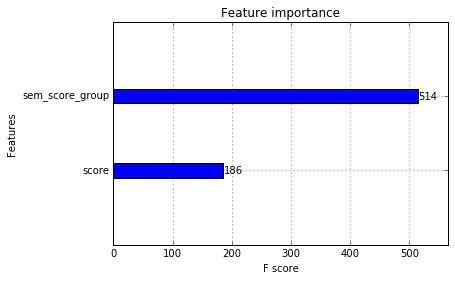

In [74]:
params = {'objective':'binary:logistic',
         'n_estimators':100,
         'learning_rate':0.02,
         'max_depth':3,
         'nthread':-1,
         'base_score':0.5}

clf = xgb.XGBClassifier(**params)

data_train = Xtrain[['id','score','score_group','sem_score_group','is_duplicate']]
data_test = Xtest[['id','score','score_group','sem_score_group','is_duplicate']]
    
clf.fit(data_train[['id','score','score_group','sem_score_group']], data_train['is_duplicate'])

pred = clf.predict_proba(data_test[['id','score','score_group','sem_score_group']])
true = data_test['is_duplicate'].values

xgb.plot_importance(clf)

print (log_loss(true, pred))

# 0.546911660588
# 0.545876360233
# 0.546307047635


#result += [log_loss(true, pred)]
       
    
#print ('Results:', [result[i] for i in range(len(result))])
#print ('Mean:', pd.DataFrame(result).mean()[0])

In [75]:
(0.546911660588 +
0.545876360233 +
0.546307047635) / 3

0.5463650228186667

In [ ]:
# Base score: 

# Results: [0.54940352297556172, 0.54789963135665087, 0.54591774101478707]
# Mean: 0.547740298449

In [ ]:
# Is that all there is? Not great so far. 

# No. There is a little bit more.

# CV and Semenych

/home/ivan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ivan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ivan/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

score_group
   id  score  score_group  is_duplicate  sem_score_group
1   1  0.381           38             0            0.419
3   3  0.000            0             0            0.001
4   4  0.200           20             0            0.092
time 10.180775880813599


/home/ivan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ivan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ivan/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

score_group
   id  score  score_group  is_duplicate  sem_score_group
0   0  0.923           92             0            0.400
2   2  0.333           33             0            0.340
3   3  0.000            0             0            0.001
time 10.372471809387207


/home/ivan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ivan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ivan/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

score_group
   id  score  score_group  is_duplicate  sem_score_group
0   0  0.923           92             0            0.412
1   1  0.381           38             0            0.417
2   2  0.333           33             0            0.335
time 10.541922092437744
Results: [0.54742358920074652, 0.5461395012438649, 0.54385481283442283]
Mean: 0.54580596776


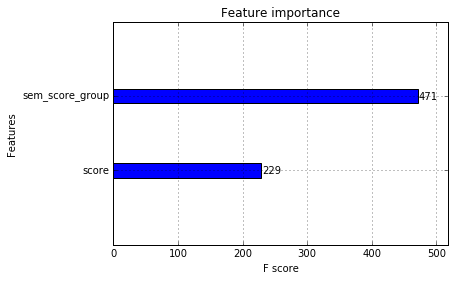

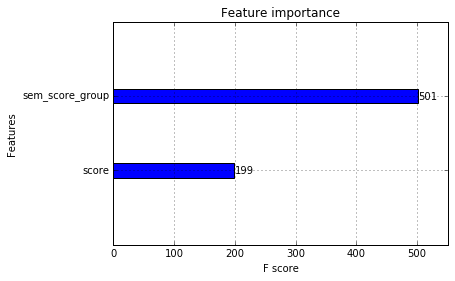

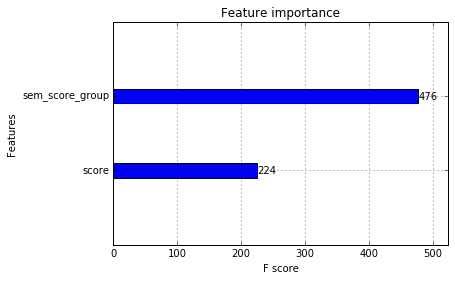

In [77]:
# Let's build  model using 3-fold CV. And Semenych inside.

params = {'objective':'binary:logistic',
         'n_estimators':100,
         'learning_rate':0.02,
         'max_depth':3,
         'nthread':-1,
         'base_score':0.5}

clf = xgb.XGBClassifier(**params)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

result = []

for train, test in kf.split(X_train):
    
    data_train = X_train.iloc[train][['id','score','score_group','is_duplicate']]
    data_test = X_train.iloc[test][['id','score','score_group','is_duplicate']]
    

    
    start = time()

    cat_features = ['score_group']

    for feature in cat_features:
    
        data_train['sem_' + feature] = 0
        data_test['sem_' + feature] = 0
    
        sem_train = data_train[[feature, 'sem_' + feature, 'is_duplicate']]
        sem_test = data_test[[feature, 'sem_' + feature, 'is_duplicate']]
    
        sem_results = Semenych(sem_train, sem_test, N_SPLITS=3, alpha=10)
    
        print (feature)
    
        data_train['sem_' + feature] = sem_results[0]['sem_' + feature]
        data_test['sem_' + feature] = sem_results[1]['sem_' + feature]
        
        print (data_train.head(3))

    print ('time', time() - start)
    
    clf.fit(data_train[['id','score','score_group','sem_score_group']], data_train['is_duplicate'])

    pred = clf.predict_proba(data_test[['id','score','score_group','sem_score_group']])
    true = data_test['is_duplicate'].values
    
    xgb.plot_importance(clf)
    
    result += [log_loss(true, pred)]
       
    
print ('Results:', [result[i] for i in range(len(result))])
print ('Mean:', pd.DataFrame(result).mean()[0])

In [ ]:
# Semenych results...
#Results: [0.54742358920074652, 0.5461395012438649, 0.54385481283442283]
#Mean: 0.54580596776

In [ ]:
# Base results:
# Results: [0.54940352297556172, 0.54789963135665087, 0.54591774101478707]
# Mean: 0.547740298449

# Spell check

In [5]:
# http://norvig.com/spell-correct.html, Peter Norvig, get big.txt from the link for this to work.

import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [43]:
correction('wrld')

'world'

In [ ]:
# We now know that there is a better formula! But at the time...

In [10]:
def Spell_Check_and_Score(cell):
    
#    words1 = [w.lower() for w in str(cell['question1']).split()]
#    words2 = [w.lower() for w in str(cell['question2']).split()]
    
#    checked_words1 = [correction(w) for w in words1]
#    checked_words2 = [correction(w) for w in words2]

    checked_words1 = [correction(w.lower()) for w in str(cell['question1']).split()]
    checked_words2 = [correction(w.lower()) for w in str(cell['question2']).split()]
    
#    n1 = len(set(checked_words1 + words1)) - len(set(words1))
#    n2 = len(set(checked_words2 + words2)) - len(set(words2))
    
#    print (cell['id'], end=', ')
    
    return (2 * len([w for w in checked_words1 if w in checked_words2]) / (len(checked_words1) + len(checked_words2)))    

In [18]:
start = time()

# X_train['spell_check_score'] = X_train.iloc[:10].apply(Spell_Check_and_Score, axis=1)

# This is how I call a multiprocessing to help

X_train['spell_check_score'] = apply_parallel(X_train, partial(process, func=partial(Spell_Check_and_Score))) 

print ('final time', time() - start) # for a 1000 but we have 400 times of that...

final time 5672.553874969482


In [ ]:
# It actually took 2 hours on 26 cores, so think before running.

In [19]:
X_train.to_csv('spelled.csv') # I can share the file, it is somewhere... but better to re-calculate it and 
# use hunspell -- must be more optimized?

In [14]:
X_train.describe()

,id,qid1,qid2,is_duplicate,spell_check_score
count,404290.000,404290.000,404290.000,404290.000,1000.000
mean,202144.500,217243.942,220955.655,0.369,0.490
std,116708.615,157751.700,159903.183,0.483,0.260
min,0.000,1.000,2.000,0.000,0.000
25%,101072.250,74437.500,74727.000,0.000,0.291
50%,202144.500,192182.000,197052.000,0.000,0.500
75%,303216.750,346573.500,354692.500,1.000,0.700
max,404289.000,537932.000,537933.000,1.000,1.000


In [ ]:
# This is the easiest known way to multi-process:

In [7]:
from functools import partial
import multiprocessing as mp

In [8]:
def process(df, func):

    return df.apply(func, axis=1)



def apply_parallel(big_data, apply_func):

    cpus = mp.cpu_count() - 2 # Leave two cores to continue working

    with mp.Pool(processes=cpus) as p:

        split_dfs = np.array_split(big_data, cpus, axis=0)

        df_pool_results = p.map(apply_func, split_dfs)

    result = pd.concat(df_pool_results, axis=0)

    return result

In [20]:
# Groups out of scores

X_train['spell_check_score_group'] = ((X_train['spell_check_score'] * 100).round()).astype(int)

In [22]:
params = {'objective':'binary:logistic',
         'n_estimators':100,
         'learning_rate':0.02,
         'max_depth':3,
         'nthread':-1,
         'base_score':0.5}

clf = xgb.XGBClassifier(**params)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

result = []

for train, test in kf.split(X_train):
    
    data_train = X_train.iloc[train][['id','spell_check_score','spell_check_score_group','is_duplicate']]
    data_test = X_train.iloc[test][['id','spell_check_score','spell_check_score_group','is_duplicate']]
    
    clf.fit(data_train[['id','spell_check_score','spell_check_score_group']], data_train['is_duplicate'])

    pred = clf.predict_proba(data_test[['id','spell_check_score','spell_check_score_group']])
    true = data_test['is_duplicate'].values
    
#    xgb.plot_importance(clf)
    
    result += [log_loss(true, pred)]
       
    
print ('Results:', [result[i] for i in range(len(result))])
print ('Mean:', pd.DataFrame(result).mean()[0])

Results: [0.56345860727226682, 0.56189888995416537, 0.55970992384725848]
Mean: 0.561689140358


# Wait! Do you say it is WORSE with spell check? 

In [28]:
X_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'spell_check_score', 'spell_check_score_group', 'score', 'score_group'],
      dtype='object')

Results: [0.54888471182482079, 0.54742154124689801, 0.54545303718273197]
Mean: 0.547253096751


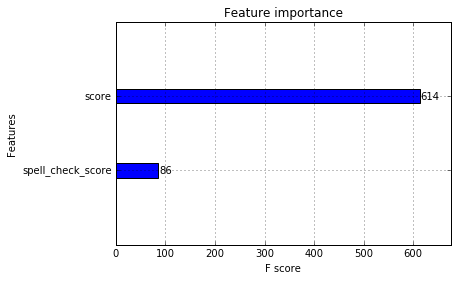

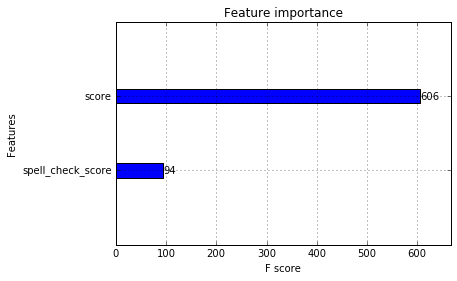

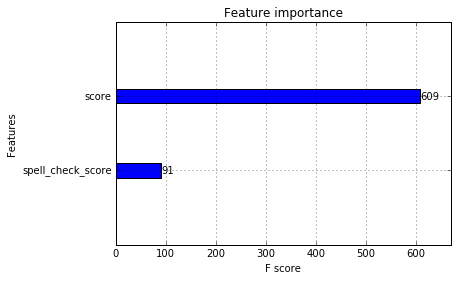

In [32]:
params = {'objective':'binary:logistic',
         'n_estimators':100,
         'learning_rate':0.02,
         'max_depth':3,
         'nthread':-1,
         'base_score':0.5}

clf = xgb.XGBClassifier(**params)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

result = []

features = ['id','spell_check_score','spell_check_score_group','score','score_group','is_duplicate']
feats = ['id','spell_check_score','spell_check_score_group','score','score_group']

for train, test in kf.split(X_train):
    
    data_train = X_train.iloc[train][features]
    data_test = X_train.iloc[test][features]
    
    clf.fit(data_train[feats], data_train['is_duplicate'])

    pred = clf.predict_proba(data_test[feats])
    true = data_test['is_duplicate'].values
    
    xgb.plot_importance(clf)
    
    result += [log_loss(true, pred)]
       
    
print ('Results:', [result[i] for i in range(len(result))])
print ('Mean:', pd.DataFrame(result).mean()[0])

In [ ]:
# But helps a little when there is the original score!